## Velocity Dispersion Testing - ctypes

Notebook to test the components of the velocity dispersion code using the ctypes method. This is less about speed/more about accuracy, as it's much easier to compare plots in python.

In [1]:
import ctypes
import time
import scipy.special as sp
from matplotlib import pyplot as plt
import numpy as np
from colossus.cosmology import cosmology
from scipy.special import gamma

cosmo = cosmology.setCosmology('planck18')
ibc = ctypes.CDLL("../cmake-build-debug/lib/libfoo.so")

## Example Galaxy Constants

In [2]:
# Proxy Galaxy, NGC3608

stellar_mass = 10**11.03

Aperture = 1.5*4.84814e-6*16.4e3 # 1.5 is SDSS Aperture, 4.84... is arcseconds to rads, 22.8e3 distance (kpc)
print("Aperture:", Aperture) # For sanity purposes

Beta = 0.1 # Dimensionless

half_light_radius = 10**0.9 # kpc
aperture = half_light_radius

Sersic_Index = 3

## Dark Matter is currently not a thing.
halo_rs = 20*half_light_radius
halo_c = 1.3

Aperture: 0.11926424399999999


### ---- Testing p_n (equation 5) ----

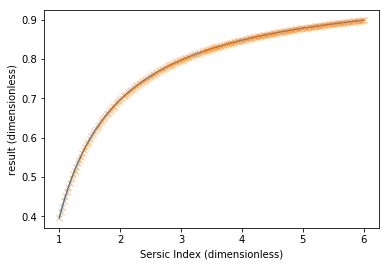

In [3]:
# Store for results
vary_sersic_index = np.linspace(1, 6, 200)
res_store_c = np.zeros_like(vary_sersic_index)
res_store_py = np.zeros_like(vary_sersic_index)

# Tell ctypes what to expect.
ibc.p_nex.argtypes = [ctypes.c_float]
ibc.p_nex.restype = ctypes.c_float 

# Call ctypes implementation
for i, n in enumerate(vary_sersic_index):
    res_store_c[i] = ibc.p_nex(float(n))

# Pythonic implementation
def p_n_func(n):
    return 1 - (0.6097/n) + (0.00563/(n**2))

for i, n in enumerate(vary_sersic_index):
    res_store_py[i] = p_n_func(n)

# Plot them both in comparison
plt.figure()
plt.plot(vary_sersic_index, res_store_c)
plt.plot(vary_sersic_index, res_store_py, 'x', alpha = 0.5)
plt.xlabel("Sersic Index (dimensionless)")
plt.ylabel("result (dimensionless)")
plt.show()

This seems fine

### ----- Testing $\Sigma(r)$ (equation 1) ------

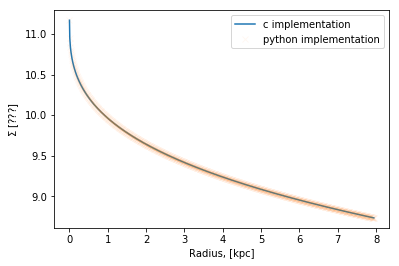

12.828744815058618


In [4]:
# Store for results
R = 0.00001
r_range, spacing = np.linspace(R, half_light_radius, 1000, retstep = True)

res_store_c = np.zeros_like(r_range)

# Tell ctypes what to expect
ibc.sersic_profile.argtypes = [ctypes.c_float, 
                               ctypes.c_float, 
                               ctypes.c_float,
                               ctypes.c_float]
                               
ibc.sersic_profile.restype = ctypes.c_float

# Ctypes implementation
for i, r in enumerate(r_range):
     res_store_c[i] = ibc.sersic_profile(float(r), float(Sersic_Index), float(half_light_radius), float(stellar_mass))
        
# Pythonic Implementation
def sersic_profile(radius, sersic_index, half_light_radius, stellar_mass):
    bn = 2*sersic_index - 1/3 + 0.009876/sersic_index
    prefactor = stellar_mass /(np.pi * half_light_radius**2)
    return prefactor * np.exp(-bn * ((radius/half_light_radius)**(1/sersic_index) -1 ))
    
    
plt.figure()
plt.plot(r_range, np.log10(res_store_c), label = "c implementation")
plt.plot(r_range, np.log10(sersic_profile(r_range, Sersic_Index, half_light_radius, stellar_mass)), 'x', alpha = 0.05, label = "python implementation")
plt.xlabel("Radius, [kpc]")
plt.ylabel("$\Sigma$ [???]")

plt.legend()
plt.show()

print(np.log10(np.sum(res_store_c * r_range)))


Perfect

### ---- Testing p0 (equation 4) ------

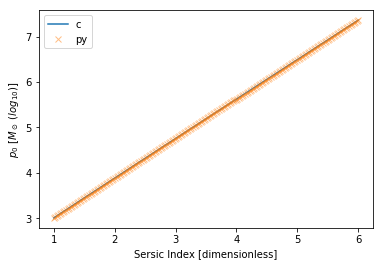

In [5]:
# Store for results
vary_sersic_index = np.linspace(1, 6, 200)
res_store_c = np.zeros_like(vary_sersic_index)
res_store_py = np.zeros_like(vary_sersic_index)

# Constants
hlr = 200.
sm = 10**10

# Tell ctypes what to expect.
ibc.rho0.argtypes = [ctypes.c_float,
                     ctypes.c_float,
                     ctypes.c_float]
ibc.rho0.restype = ctypes.c_float 

# Call ctypes implementation
for i, n in enumerate(vary_sersic_index):
    res_store_c[i] = ibc.rho0(hlr, float(n), sm)
    
def rho0(half_light_radius, sersic_index, stellar_mass):
    sigma = sersic_profile(0., sersic_index, half_light_radius, stellar_mass)
    bn = 2*sersic_index - 1/3 + 0.009876/sersic_index
    right = gamma(2.*sersic_index)/gamma(sersic_index * (3. - p_n_func(sersic_index) ))
    return sigma * bn**(sersic_index*(1-p_n_func(sersic_index))) * right / (2 * half_light_radius)
    
plt.figure()
plt.plot(vary_sersic_index, np.log10(res_store_c), label = "c" )
plt.plot(vary_sersic_index, np.log10(rho0(hlr, vary_sersic_index, sm)), 'x', alpha = 0.5, label = "py")
plt.xlabel("Sersic Index [dimensionless]")
plt.ylabel("$p_0$ [$M_\odot$ ($log_{10}$)]")
plt.legend()
plt.show()

### ----- Testing de-projected density $\rho(r)$ (equation 3) ----- 

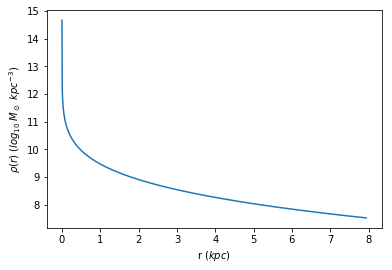

In [6]:
# Some arbiraty constants.

R = 0.001
r_range, spacing = np.linspace(0.00001, half_light_radius, 1000, retstep = True)

omega_m = cosmo.Om0
H = cosmo.H0

store = np.zeros_like(r_range)

# Tell Ctypes what to expect
ibc.density.argtypes = [ctypes.c_float,
                        ctypes.c_float,
                        ctypes.c_float,
                        ctypes.c_float,
                        ctypes.c_float,
                        ctypes.c_float,
                        ctypes.c_float,
                        ctypes.c_float]
ibc.density.restype = ctypes.c_float 

# Loop over and store values
for i, value in enumerate(r_range):
    store[i] = ibc.density(value, half_light_radius, Sersic_Index, stellar_mass, halo_rs, halo_c, omega_m, H)
    
plt.figure()
plt.plot(r_range, np.log10(store) )
plt.xlabel(r"r ($kpc$)")
plt.ylabel(r"$\rho (r)$ ($log_{10}$ $M_\odot$ $kpc^{-3}$)")
plt.show()


In [7]:
ibc.total_mass.argtypes = [ctypes.c_float, 
                            ctypes.c_float, 
                            ctypes.c_float,
                            ctypes.c_float,
                            ctypes.c_float,
                            ctypes.c_float,
                            ctypes.c_float,
                            ctypes.c_float]

ibc.total_mass.restype = ctypes.c_float 

/Users/christophermarsden/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/Users/christophermarsden/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


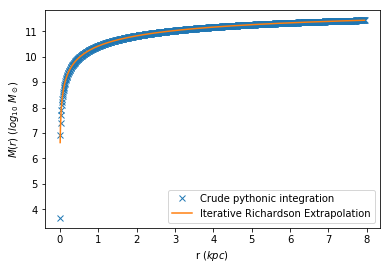

In [8]:
Integral_store = np.zeros_like(r_range)
C_integral_store = np.zeros_like(r_range)

for i, value in enumerate(r_range):
    Integral_store[i] = np.sum(store[:i] * 4 * np.pi *(r_range[:i]**2) * spacing)
    C_integral_store[i] = ibc.total_mass(value, half_light_radius, Sersic_Index, stellar_mass, halo_rs, halo_c, omega_m, H)


plt.figure()
plt.plot(r_range,  np.log10(Integral_store), 'x', label = 'Crude pythonic integration')
plt.plot(r_range, np.log10(C_integral_store), label = 'Iterative Richardson Extrapolation')
plt.xlabel(r"r ($kpc$)")
plt.ylabel(r"$M(r)$ ($log_{10}$ $M_\odot$)")
plt.legend()
plt.show()


### K_Kernel

#### incbeta

In [9]:
def better_beta(a, b, z):
    '''Beta function under geometric transformation'''
    if a < 0:
        beta = pow(z, a) * pow((1 - z), b) + (a + b) * better_beta(a + 1, b, z);
        beta = beta/a
        return beta
    else:
        beta = sp.betainc(a, b, z)*sp.beta(a, b) # sp.betainc is the regularized version.
        return beta

In [10]:
ibc.incbeta.argtypes = [ctypes.c_float, ctypes.c_float, ctypes.c_float]
ibc.incbeta.restype = ctypes.c_float

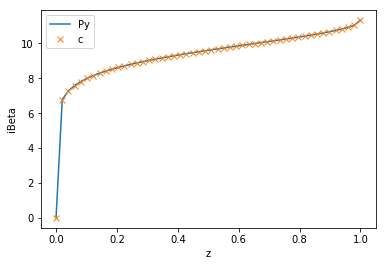

In [11]:
vary_u = np.linspace(0, 1)
store_py = np.zeros_like(vary_u)
store_c = np.zeros_like(vary_u)

b = 0.5 # Keep const
a = 0.1

for i, u in enumerate(vary_u):
    store_py[i] = better_beta(a, b, u)
    store_c[i] = ibc.incbeta(a, b, u)
    
plt.figure()
plt.plot(vary_u, store_py, label="Py")
plt.plot(vary_u, store_c, 'x', label="c")
plt.legend()
plt.xlabel("z")
plt.ylabel("iBeta")
plt.show()



#### full kernel

In [12]:
ibc.K_Kernel.argtypes = [ctypes.c_float, ctypes.c_float]
ibc.K_Kernel.restype = ctypes.c_float 

In [13]:
def pythonic_K(u, B):
    
    prefactor = 0.5 * u**(2*B-1)
    
    term1 = ((3/2) - B) * (np.pi**0.5) * ( (sp.gamma(B - 0.5)) / (sp.gamma(B)) )
    term2 = B * (better_beta(B + 0.5, 0.5, 1/(u**2)))
    term3 = better_beta(B - 0.5, 0.5, 1/(u**2))
    
    res = prefactor * (term1 + term2 - term3)
    return res

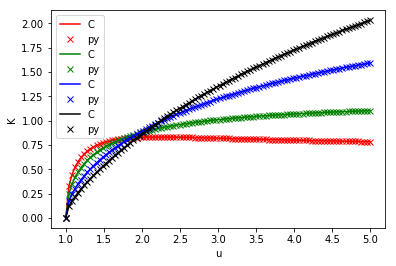

In [14]:
Beta_elements = [-0.2, 0.1, 0.4, 0.6]
colors = ['r', 'g', 'b', 'k']
u_range = np.linspace(1, 5, 100)
k_store = np.zeros_like(u_range)
k_store_py = np.zeros_like(u_range)

plt.figure()

for j, Beta_value in enumerate(Beta_elements):

    for i, u in enumerate(u_range):
        k_store[i] = ibc.K_Kernel(u, Beta_value)
        k_store_py[i] = pythonic_K(u, Beta_value)

    plt.plot(u_range, k_store, colors[j], label = 'C')
    plt.plot(u_range, k_store_py, colors[j]+'x', label = 'py')

plt.xlabel('u')
plt.ylabel('K')
plt.legend()
plt.show()

## First Integral Internals

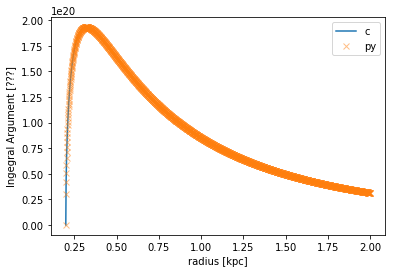

In [15]:
ibc.first_integral_internals.argtypes = [ctypes.c_float, 
                                         ctypes.c_float,
                                         ctypes.c_float, 
                                         ctypes.c_float,
                                         ctypes.c_float, 
                                         ctypes.c_float,
                                         ctypes.c_float, 
                                         ctypes.c_float,
                                         ctypes.c_float, 
                                         ctypes.c_float]

ibc.first_integral_internals.restype = ctypes.c_float 

R = 0.2
r_range = np.linspace(R, 2, 2000)
res_store = np.zeros_like(r_range)
py_res_store = np.zeros_like(r_range)

for i, r in enumerate(r_range):
    res_store[i] = ibc.first_integral_internals(r, R, Beta, half_light_radius, Sersic_Index, stellar_mass, halo_rs, halo_c, omega_m, H)
    kernal = ibc.K_Kernel(r/R, Beta)
    density = ibc.density(r, half_light_radius, Sersic_Index, stellar_mass, halo_rs, halo_c, omega_m, H)
    mass = ibc.total_mass(r, half_light_radius, Sersic_Index, stellar_mass, halo_rs, halo_c, omega_m, H)
    py_res_store[i] = kernal * density * mass / r

plt.figure()
plt.plot(r_range, res_store, label = 'c')
plt.plot(r_range, py_res_store,  'x', label = 'py', alpha = 0.5 )
plt.xlabel("radius [kpc]")
plt.ylabel("Ingegral Argument [???]")

plt.legend()
plt.show()


### --- $\sigma_{los}$ (equation 8) ---

In [16]:
Radii = np.linspace(0, 1, 100)
VD_store = np.zeros_like(Radii)

ibc.VD_los.argtypes =   [ctypes.c_float, 
                         ctypes.c_float,
                         ctypes.c_float, 
                         ctypes.c_float,
                         ctypes.c_float, 
                         ctypes.c_float,
                         ctypes.c_float,
                         ctypes.c_float,
                         ctypes.c_float]

ibc.VD_los.restype = ctypes.c_float

start_time = time.time()
for i, R in enumerate(Radii):
    VD_store[i] = ibc.VD_los(R, Beta, half_light_radius, Sersic_Index, stellar_mass, halo_rs, halo_c, omega_m, H)
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.6878409385681152 seconds ---


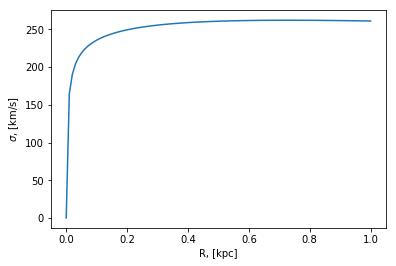

In [17]:
plt.figure()
plt.plot(Radii, VD_store)
plt.xlabel("R, [kpc]")
plt.ylabel("$\sigma$, [km/s]")
plt.show()

### --- $\sigma_{ap}$ final velocity dispersion ---

In [18]:
ibc.VD.argtypes =   [ctypes.c_float, 
                     ctypes.c_float,
                     ctypes.c_float, 
                     ctypes.c_float,
                     ctypes.c_float, 
                     ctypes.c_float,
                     ctypes.c_float,
                     ctypes.c_float,
                     ctypes.c_float]

ibc.VD.restype = ctypes.c_float

VD = ibc.VD(Aperture, Beta, half_light_radius, Sersic_Index, stellar_mass, halo_rs, halo_c, omega_m, H)

print(VD, "log10:", np.log10(VD))






225.87193298339844 log10: 2.3538622685134083
